In [23]:
import pandas as pd
import json
import os
import altair as alt
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance
# sns.set(style='ticks', context='paper', font='CMU Sans Serif')
sns.set(style='ticks', context='paper')
from collections import defaultdict
import numpy as np

In [2]:
def pn_distance(a, b, p):
    x = a.quantile(p)
    y = b.quantile(p)
    return (y - x) / x
    
def p99_distance(a, b):
    return pn_distance(a, b, 0.99)

In [3]:
def create_record(mix):
    file2matrix = {
        '../../workload/spatials/cluster_a_2_16.json': 'Matrix A',
        '../../workload/spatials/cluster_b_2_16.json': 'Matrix B',
        '../../workload/spatials/cluster_c_2_16.json': 'Matrix C',
    }
    file2dist = {
        '../../workload/distributions/facebook/webserver-all.txt': 'WebServer',
        '../../workload/distributions/facebook/hadoop-all.txt': 'Hadoop',
        '../../workload/distributions/facebook/cachefollower-all.txt': 'CacheFollower',
    }
    file2oversub = {
        'spec/cluster_1_to_1.json': '1-to-1',
        'spec/cluster_2_to_1.json': '2-to-1',
        'spec/cluster_4_to_1.json': '4-to-1',
    }

    mix_id = mix['id']
    mix_dir = f'../data/{mix_id}'
    
    # Load info
    with open(f'{mix_dir}/pmn-m/loads.json') as f:
        loads = json.load(f)
        loads.sort(reverse=True)
    loads = pd.DataFrame(loads, columns=['load'])
    max_load = loads['load'][0]
    idx = int(len(loads) * 0.1)
    top10pct_load = loads['load'][:idx].mean()

    # Accuracy metrics
    df_ns3 = pd.read_csv(f'{mix_dir}/ns3/records.csv')
    df_pmn_m = pd.read_csv(f'{mix_dir}/pmn-m/records.csv')
    df_pmn_m_path = pd.read_csv(f'{mix_dir}/pmn-m/records.csv')
    df_ns3_path = pd.read_csv(f'{mix_dir}/ns3-path-one/records.csv')
    # df_flowsim = pd.read_csv(f'{mix_dir}/ns3-path-one/records.csv')
    df_flowsim = pd.read_csv(f'{mix_dir}/flowsim/records.csv')
    
    # filter results for flows tracersing the specific path
    
    filter_list_ns3=[]
    with open(f'{mix_dir}/ns3-path-one/path.txt') as file:
        for line_idx,line in enumerate(file):
            if line_idx==0:
                src_dst_pair = line.rstrip()
            elif line_idx==1:
                filter_list_ns3=[int(x) for x in line.rstrip().split(',')]
    filter_list_pmn=[]
    with open(f'{mix_dir}/pmn-m-path/path.txt') as file:
        for line_idx,line in enumerate(file):
            if line_idx==1:
                filter_list_pmn=[int(x) for x in line.rstrip().split(',')]
    
    df_ns3=df_ns3.loc[df_ns3['flow_id'].isin(filter_list_ns3)]
    df_pmn_m=df_pmn_m.loc[df_pmn_m['flow_id'].isin(filter_list_ns3)]
    df_pmn_m_path=df_pmn_m_path.loc[df_pmn_m_path['flow_id'].isin(filter_list_pmn)]
    df_ns3_path=df_ns3_path.loc[df_ns3_path['flow_id'].isin(filter_list_ns3)]
    df_flowsim=df_flowsim.loc[df_flowsim['flow_id'].isin(filter_list_ns3)]
    # df_flowsim=df_ns3_path
    print(f"{mix_id}: path={src_dst_pair}, len=",df_ns3.shape[0],df_pmn_m.shape[0],df_pmn_m_path.shape[0],df_ns3_path.shape[0],df_flowsim.shape[0])
    # if not (df_ns3.shape[0]==df_pmn_m.shape[0]==df_pmn_m_path.shape[0]==df_ns3_path.shape[0]==df_flowsim.shape[0]):
    #     return {
    #     'id': mix['id'],
    #     'matrix': file2matrix[mix['spatial']],
    #     'size_dist': file2dist[mix['size_dist']],
    #     'lognorm_sigma': mix['lognorm_sigma'],
    #     'max_load_spec': mix['max_load'],
    #     'max_load': max_load,
    #     'top10pct_load': top10pct_load,
    #     'oversub': file2oversub[mix['cluster']],
    #     'was__ns3__pmn_m': None,
    #     'p99__ns3__pmn_m': None,
    #     'was__ns3__pmn_m_path': None,
    #     'p99__ns3__pmn_m_path': None,
    #     'was__ns3__ns3_path': None,
    #     'p99__ns3__ns3_path': None,
    #     'was__ns3__flowsim': None,
    #     'p99__ns3__flowsim': None,
    # }
    
    was__ns3__pmn_m = wasserstein_distance(df_ns3['slowdown'], df_pmn_m['slowdown'])
    p99__ns3__pmn_m = p99_distance(df_ns3['slowdown'], df_pmn_m['slowdown'])
    was__ns3__pmn_m_path = wasserstein_distance(df_ns3['slowdown'], df_pmn_m_path['slowdown'])
    p99__ns3__pmn_m_path = p99_distance(df_ns3['slowdown'], df_pmn_m_path['slowdown'])
    was__ns3__ns3_path = wasserstein_distance(df_ns3['slowdown'], df_ns3_path['slowdown'])
    p99__ns3__ns3_path = p99_distance(df_ns3['slowdown'], df_ns3_path['slowdown'])
    was__ns3__flowsim = wasserstein_distance(df_ns3['slowdown'], df_flowsim['slowdown'])
    p99__ns3__flowsim = p99_distance(df_ns3['slowdown'], df_flowsim['slowdown'])

    record = {
        'id': mix['id'],
        'matrix': file2matrix[mix['spatial']],
        'size_dist': file2dist[mix['size_dist']],
        'lognorm_sigma': mix['lognorm_sigma'],
        'max_load_spec': mix['max_load'],
        'max_load': max_load,
        'top10pct_load': top10pct_load,
        'oversub': file2oversub[mix['cluster']],
        'was__ns3__pmn_m': was__ns3__pmn_m,
        'p99__ns3__pmn_m': p99__ns3__pmn_m,
        'was__ns3__pmn_m_path': was__ns3__pmn_m_path,
        'p99__ns3__pmn_m_path': p99__ns3__pmn_m_path,
        'was__ns3__ns3_path': was__ns3__ns3_path,
        'p99__ns3__ns3_path': p99__ns3__ns3_path,
        'was__ns3__flowsim': was__ns3__flowsim,
        'p99__ns3__flowsim': p99__ns3__flowsim,
    }
    return record
    
def get_records():
    mix_file = '../spec/all.mix.json'
    csv_file = 'sensitivity_path_one.csv'
    if os.path.exists(csv_file):
        mixes = pd.read_csv(csv_file)
    else:
        with open(mix_file) as f:
            mixes = json.load(f) 
        # mixes=[item for item in mixes if item['id']>179]
        mixes = pd.DataFrame(list(map(create_record, mixes)))
        mixes.to_csv('sensitivity_path_one.csv', index=False)
    return mixes

records = get_records()

## Max load

### CDFs

In [4]:
def ecdfplot(df, x):
    df['pct'] = df.groupby(by=['kind'], as_index=False)[x].rank(pct=True)
    plt.figure(figsize=(4, 1.5))
    ax = sns.lineplot(data=df, x=x, y='pct', hue='kind', style='kind', ci=None)
    ax.get_legend().set_title('Max load (top 10% avg)')
    ax.get_legend().set_frame_on(False)
    sns.despine()
    plt.ylabel('CDF')
    
def percentify(x):
    return f'{int(round(x, 2) * 100)}%'


In [5]:
print(records['max_load'].min())
print(records['max_load'].max())

0.2622437225038556
0.8088832507076631


In [8]:
import numpy as np
worst_low_id=records['p99__ns3__ns3_path'].idxmin()
worst_low_p99=records['p99__ns3__ns3_path'].min()
worst_high_id=records['p99__ns3__ns3_path'].idxmax()
worst_high_p99=records['p99__ns3__ns3_path'].max()
print("{}:{}, {}:{}".format(worst_low_id, worst_low_p99, worst_high_id, worst_high_p99))
print(records[records['id']==worst_low_id])
print(records[records['id']==worst_high_id])

63:-0.3383176075416743, 20:0.0385329699344392
    id    matrix  size_dist  lognorm_sigma  max_load_spec  max_load  \
63  63  Matrix B  WebServer            2.0       0.731133  0.808883   

    top10pct_load oversub  was__ns3__pmn_m  p99__ns3__pmn_m  \
63       0.610737  2-to-1         0.019756        -0.060808   

    was__ns3__pmn_m_path  p99__ns3__pmn_m_path  was__ns3__ns3_path  \
63              0.019756             -0.060808            0.010652   

    p99__ns3__ns3_path  was__ns3__flowsim  p99__ns3__flowsim kind  
63           -0.338318           0.020461          -0.410759  all  
    id    matrix      size_dist  lognorm_sigma  max_load_spec  max_load  \
20  20  Matrix A  CacheFollower            2.0        0.42466  0.427381   

    top10pct_load oversub  was__ns3__pmn_m  p99__ns3__pmn_m  \
20       0.276615  4-to-1         0.154739         0.099635   

    was__ns3__pmn_m_path  p99__ns3__pmn_m_path  was__ns3__ns3_path  \
20              0.162096              0.092513            0

findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.


63: path=230-229,230-284,284-229,350,6130, len= 350 350 350 350


findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.


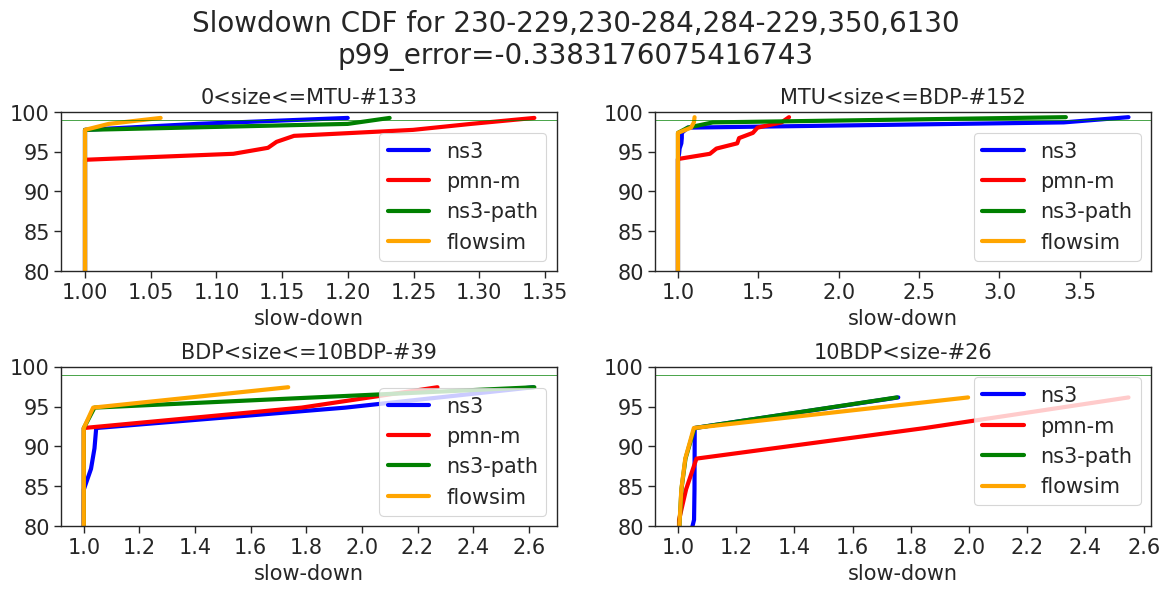

In [10]:
_fontsize=15

mix_dir = f'../data/{worst_low_id}'
error=  worst_low_p99
# Accuracy metrics
df_ns3 = pd.read_csv(f'{mix_dir}/ns3/records.csv')
df_pmn_m = pd.read_csv(f'{mix_dir}/pmn-m/records.csv')
df_ns3_path = pd.read_csv(f'{mix_dir}/ns3-path-one/records.csv')
df_flowsim = pd.read_csv(f'{mix_dir}/flowsim/records.csv')
# df_flowsim = df_ns3_path
filter_list_ns3=[]
with open(f'{mix_dir}/ns3-path-one/path.txt') as file:
    for line_idx,line in enumerate(file):
        if line_idx==0:
            src_dst_pair = line.rstrip()
        elif line_idx==1:
            filter_list_ns3=[int(x) for x in line.rstrip().split(',')]

df_ns3=df_ns3.loc[df_ns3['flow_id'].isin(filter_list_ns3)]
df_pmn_m=df_pmn_m.loc[df_pmn_m['flow_id'].isin(filter_list_ns3)]
df_ns3_path=df_ns3_path.loc[df_ns3_path['flow_id'].isin(filter_list_ns3)]
df_flowsim=df_flowsim.loc[df_flowsim['flow_id'].isin(filter_list_ns3)]
sizes=df_ns3['size']
sldn_ns3=df_ns3['slowdown']
sldn_pmn_m=df_pmn_m['slowdown']
sldn_ns3_path=df_ns3_path['slowdown']
sldn_flowsim=df_flowsim['slowdown']
print(f"{worst_low_id}: path={src_dst_pair}, len=",df_ns3.shape[0],df_pmn_m.shape[0],df_ns3_path.shape[0],df_flowsim.shape[0])
assert df_ns3.shape[0]==df_pmn_m.shape[0]==df_ns3_path.shape[0]==sldn_flowsim.shape[0]

labels = {0: '0<size<=MTU', 1:'MTU<size<=BDP', 2:'BDP<size<=10BDP', 3:'10BDP<size'}
MTU=1000
BDP = 15 * MTU

bin=np.digitize(sizes, [MTU, BDP, 10 * BDP])
plt.figure(0,figsize=(12, 6))
plt.suptitle(f"Slowdown CDF for {src_dst_pair}\np99_error={error}",fontsize=_fontsize+5)
plt.rcParams['legend.fontsize'] = _fontsize
for i in range(len(labels)):
    tmp_sldn_ns3 = np.extract(bin==i, sldn_ns3)
    tmp_sldn_pmn_m = np.extract(bin==i, sldn_pmn_m)
    tmp_sldn_ns3_path = np.extract(bin==i, sldn_ns3_path)
    tmp_sldn_flowsim = np.extract(bin==i, sldn_flowsim)
    
    plt.subplot(2, 2, i + 1)
    plt.title(f"{labels[i]}-#{len(tmp_sldn_ns3)}",fontsize=_fontsize)
    plt.plot(np.sort(tmp_sldn_ns3), (np.arange(len(tmp_sldn_ns3))/len(tmp_sldn_ns3)*100), label='ns3', color='blue', linewidth=3)
    plt.plot(np.sort(tmp_sldn_pmn_m), (np.arange(len(tmp_sldn_pmn_m))/len(tmp_sldn_pmn_m)*100), label='pmn-m', color='red', linewidth=3)
    plt.plot(np.sort(tmp_sldn_ns3_path), (np.arange(len(tmp_sldn_ns3_path))/len(tmp_sldn_ns3_path)*100), label='ns3-path', color='green', linewidth=3)
    plt.plot(np.sort(tmp_sldn_flowsim), (np.arange(len(tmp_sldn_flowsim))/len(tmp_sldn_flowsim)*100), label='flowsim', color='orange', linewidth=3)
    plt.axhline(99, color='green', linewidth=0.5)
    # plt.xscale('log')
    plt.ylim(80, 100)
    plt.xlabel('slow-down', fontsize=_fontsize)
    plt.yticks(fontsize=_fontsize)
    plt.xticks(fontsize=_fontsize)
    plt.legend()
plt.tight_layout()

findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.


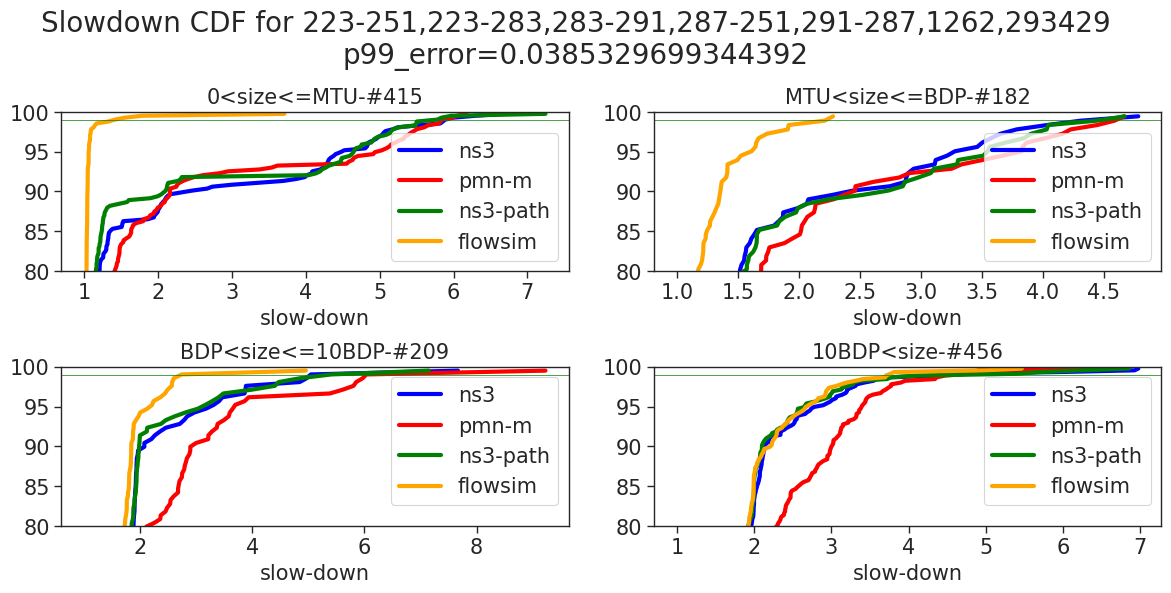

In [11]:
_fontsize=15

mix_dir = f'../data/{worst_high_id}'
error=  worst_high_p99

# Accuracy metrics
df_ns3 = pd.read_csv(f'{mix_dir}/ns3/records.csv')
df_pmn_m = pd.read_csv(f'{mix_dir}/pmn-m/records.csv')
df_ns3_path = pd.read_csv(f'{mix_dir}/ns3-path-one/records.csv')
df_flowsim = pd.read_csv(f'{mix_dir}/flowsim/records.csv')
# df_flowsim = df_ns3_path
with open(f'{mix_dir}/ns3-path-one/path.txt') as file:
    for line_idx,line in enumerate(file):
        if line_idx==0:
            src_dst_pair = line.rstrip()
        elif line_idx==1:
            filter_list_ns3=[int(x) for x in line.rstrip().split(',')]

df_ns3=df_ns3.loc[df_ns3['flow_id'].isin(filter_list_ns3)]
df_pmn_m=df_pmn_m.loc[df_pmn_m['flow_id'].isin(filter_list_ns3)]
df_ns3_path=df_ns3_path.loc[df_ns3_path['flow_id'].isin(filter_list_ns3)]
df_flowsim=df_flowsim.loc[df_flowsim['flow_id'].isin(filter_list_ns3)]
sizes=df_ns3['size']
sldn_ns3=df_ns3['slowdown']
sldn_pmn_m=df_pmn_m['slowdown']
sldn_ns3_path=df_ns3_path['slowdown']
sldn_flowsim=df_flowsim['slowdown']
assert df_ns3.shape[0]==df_pmn_m.shape[0]==df_ns3_path.shape[0]==sldn_flowsim.shape[0]

labels = {0: '0<size<=MTU', 1:'MTU<size<=BDP', 2:'BDP<size<=10BDP', 3:'10BDP<size'}
MTU=1000
BDP = 15 * MTU

bin=np.digitize(sizes, [MTU, BDP, 10 * BDP])
plt.figure(0,figsize=(12, 6))
plt.suptitle(f"Slowdown CDF for {src_dst_pair}\np99_error={error}",fontsize=_fontsize+5)
plt.rcParams['legend.fontsize'] = _fontsize
for i in range(len(labels)):
    tmp_sldn_ns3 = np.extract(bin==i, sldn_ns3)
    tmp_sldn_pmn_m = np.extract(bin==i, sldn_pmn_m)
    tmp_sldn_ns3_path = np.extract(bin==i, sldn_ns3_path)
    tmp_sldn_flowsim = np.extract(bin==i, sldn_flowsim)
    
    plt.subplot(2, 2, i + 1)
    plt.title(f"{labels[i]}-#{len(tmp_sldn_ns3)}",fontsize=_fontsize)
    plt.plot(np.sort(tmp_sldn_ns3), (np.arange(len(tmp_sldn_ns3))/len(tmp_sldn_ns3)*100), label='ns3', color='blue', linewidth=3)
    plt.plot(np.sort(tmp_sldn_pmn_m), (np.arange(len(tmp_sldn_pmn_m))/len(tmp_sldn_pmn_m)*100), label='pmn-m', color='red', linewidth=3)
    plt.plot(np.sort(tmp_sldn_ns3_path), (np.arange(len(tmp_sldn_ns3_path))/len(tmp_sldn_ns3_path)*100), label='ns3-path', color='green', linewidth=3)
    plt.plot(np.sort(tmp_sldn_flowsim), (np.arange(len(tmp_sldn_flowsim))/len(tmp_sldn_flowsim)*100), label='flowsim', color='orange', linewidth=3)
    plt.axhline(99, color='green', linewidth=0.5)
    # plt.xscale('log')
    plt.ylim(80, 100)
    plt.xlabel('slow-down', fontsize=_fontsize)
    plt.yticks(fontsize=_fontsize)
    plt.xticks(fontsize=_fontsize)
    plt.legend()
plt.tight_layout()



In [6]:
records = records.sort_values(by='max_load')
n = round(len(records) / 3)
records_l = records.iloc[0:n].copy()
records_m = records.iloc[n:n+n].copy()
records_h = records.iloc[n+n:].copy()

# records_l = records[records['max_load'] <= 0.5].copy()
# records_m = records[records['max_load'] <= 0.65].copy()
# records_h = records[records['max_load'] <= 1.0].copy()
max_load = records['max_load'].max()

max_load_l_min = records_l['max_load'].min()
max_load_m_min = records_m['max_load'].min()
max_load_h_min = records_h['max_load'].min()

max_load_l_max = records_l['max_load'].max()
max_load_m_max = records_m['max_load'].max()
max_load_h_max = records_h['max_load'].max()

top10pct_load_l_min = records_l['top10pct_load'].min()
top10pct_load_m_min = records_m['top10pct_load'].min()
top10pct_load_h_min = records_h['top10pct_load'].min()

top10pct_load_l_max = records_l['top10pct_load'].max()
top10pct_load_m_max = records_m['top10pct_load'].max()
top10pct_load_h_max = records_h['top10pct_load'].max()

records_l.loc[:, 'kind'] = 'low'
records_m.loc[:, 'kind'] = 'medium'
records_h.loc[:, 'kind'] = 'high'
records.loc[:, 'kind'] = 'all'
records_lmh = pd.concat([records_l, records_h, records_m, records], ignore_index=True)

x_lim_range=(-1.0, 1.0)

In [49]:
records_lmh['p99__ns3__ns3_path'] = records_lmh['p99__ns3__ns3_path'].abs()
records_lmh['p99__ns3__flowsim'] = records_lmh['p99__ns3__flowsim'].abs()
records_lmh['p99__ns3__pmn_m'] = records_lmh['p99__ns3__pmn_m'].abs()
records_lmh['p99__ns3__pmn_m_path'] = records_lmh['p99__ns3__pmn_m_path'].abs()
x_lim_range=(0, 1.0)

/tmp/ipykernel_1130633/2982284330.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['pct'] = data[each].rank(pct=True)
/tmp/ipykernel_1130633/2982284330.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax=sns.lineplot(data = data, x = each, y = 'pct', color = color_list[i], ci = None, ax=axs)
/tmp/ipykernel_1130633/2982284330.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['pct'] = data[each].rank(pct=True)
/tmp/ipykernel_1130633/2982284330

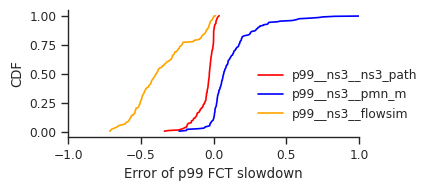

In [7]:
# column_list=['p99__ns3__ns3_path','p99__ns3__flowsim','p99__ns3__pmn_m','p99__ns3__pmn_m_path']
column_list=['p99__ns3__ns3_path','p99__ns3__pmn_m','p99__ns3__flowsim']
color_list=["red","blue", "orange","black"]
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(3.7, 2.0), sharex=True)
for i,each in enumerate(column_list):
    data=records_lmh.loc[records_lmh['kind'] == 'all']
    data['pct'] = data[each].rank(pct=True)
    ax=sns.lineplot(data = data, x = each, y = 'pct', color = color_list[i], ci = None, ax=axs)
    # handles = ax.get_legend().get_lines()
    # ax.get_legend().remove()
title=''
# labels=[
#     f'{percentify(max_load_l_min)} - {percentify(max_load_l_max)} ({percentify(top10pct_load_l_max)})',
#     f'{percentify(max_load_h_min)} - {percentify(max_load_h_max)} ({percentify(top10pct_load_h_max)})',
#     f'{percentify(max_load_m_min)} - {percentify(max_load_m_max)} ({percentify(top10pct_load_m_max)})',
#     'all scenarios'
# ]
# labels=column_list
labels=['p99__ns3__ns3_path','p99__ns3__pmn_m','p99__ns3__flowsim']
# XXX: This is a dirty hack. Look carefully at the labels!
fig.legend(labels=labels, title=title, loc='lower right', frameon=False, ncol=1, bbox_to_anchor=(1.15, 0.32))
sns.despine()
fig.tight_layout()
plt.xlabel('Error of p99 FCT slowdown')
plt.ylabel('CDF')
plt.xlim(x_lim_range)
plt.savefig('figs/error-dist-all-0.pdf', bbox_inches='tight')

findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.


p99__ns3__ns3_path:  0.0 0.3383176075416743
p99__ns3__ns3_path:  0.0 0.3383176075416743
p99__ns3__pmn_m:  0.0009469511641486 1.211094668561597
p99__ns3__pmn_m:  0.0009469511641486 1.211094668561597


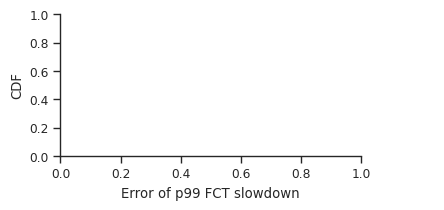

In [19]:
records_lmh_sorted=records_lmh.sort_values(by='lognorm_sigma')
# column_list=['p99__ns3__ns3_path','p99__ns3__flowsim','p99__ns3__pmn_m','p99__ns3__pmn_m_path']
column_list=['p99__ns3__ns3_path','p99__ns3__pmn_m']
column_list_2=[1,2]
color_list=["red","blue", "orange","black"]
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(3.7, 2.0), sharex=True)
for i,each in enumerate(column_list):
    for i2,each2 in enumerate(column_list_2):
        data=records_lmh_sorted.loc[(records_lmh_sorted['kind'] == 'all') & (records_lmh_sorted['lognorm_sigma'] == column_list_2[i2])]
        data['pct'] = data[each].rank(pct=True)
        ax=sns.scatterplot(data = data, x = each, y = 'pct', color = color_list[i], ax=axs)
        print(f"{each}: ",records_lmh_sorted[each].min(),records_lmh_sorted[each].max())
        # handles = ax.get_legend().get_lines()
        # ax.get_legend().remove()
title=''
# labels=[
#     f'{percentify(max_load_l_min)} - {percentify(max_load_l_max)} ({percentify(top10pct_load_l_max)})',
#     f'{percentify(max_load_h_min)} - {percentify(max_load_h_max)} ({percentify(top10pct_load_h_max)})',
#     f'{percentify(max_load_m_min)} - {percentify(max_load_m_max)} ({percentify(top10pct_load_m_max)})',
#     'all scenarios'
# ]
# labels=column_list
labels=['p99__ns3__ns3_path','p99__ns3__pmn_m','p99__ns3__flowsim']
# XXX: This is a dirty hack. Look carefully at the labels!
fig.legend(labels=labels, title=title, loc='lower right', frameon=False, ncol=1, bbox_to_anchor=(1.15, 0.32))
sns.despine()
fig.tight_layout()
plt.xlabel('Error of p99 FCT slowdown')
plt.ylabel('CDF')
plt.savefig('figs/error-dist-all-0.pdf', bbox_inches='tight')

/tmp/ipykernel_2989970/1045101413.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(data=records_lmh, x='p99__ns3__ns3_path', y='pct', hue='kind', style='kind', ci=None)
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: 

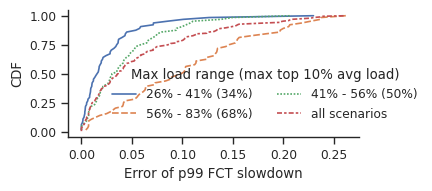

In [39]:
# records_lmh=abs(records_lmh)
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(3.7, 2.0), sharex=True)
# records_lmh['pct'] = records_lmh.groupby(by=['kind'], as_index=False)['p99__ns3__pmn_m'].rank(pct=True)
# ax = sns.lineplot(data=records_lmh, x='p99__ns3__pmn_m', y='pct', hue='kind', style='kind', ci=None)

# records_lmh['pct'] = records_lmh.groupby(by=['kind'], as_index=False)['p99__ns3__pmn_m_path'].rank(pct=True)
# ax = sns.lineplot(data=records_lmh, x='p99__ns3__pmn_m_path', y='pct', hue='kind', style='kind', ci=None)

records_lmh['pct'] = records_lmh.groupby(by=['kind'], as_index=False)['p99__ns3__ns3_path'].rank(pct=True)
ax = sns.lineplot(data=records_lmh, x='p99__ns3__ns3_path', y='pct', hue='kind', style='kind', ci=None)

# records_lmh['pct'] = records_lmh.groupby(by=['kind'], as_index=False)['p99__ns3__flowsim'].rank(pct=True)
# ax = sns.lineplot(data=records_lmh, x='p99__ns3__flowsim', y='pct', hue='kind', style='kind', ci=None)

handles = ax.get_legend().get_lines()
ax.get_legend().remove()
title='Max load range (max top 10% avg load)'
labels=[
    f'{percentify(max_load_l_min)} - {percentify(max_load_l_max)} ({percentify(top10pct_load_l_max)})',
    f'{percentify(max_load_h_min)} - {percentify(max_load_h_max)} ({percentify(top10pct_load_h_max)})',
    f'{percentify(max_load_m_min)} - {percentify(max_load_m_max)} ({percentify(top10pct_load_m_max)})',
    'all scenarios'
]
# XXX: This is a dirty hack. Look carefully at the labels!
fig.legend(handles=handles, labels=labels, title=title, loc='lower right', frameon=False, ncol=2, bbox_to_anchor=(1.15, 0.32))
sns.despine()
fig.tight_layout()
plt.xlabel('Error of p99 FCT slowdown')
plt.ylabel('CDF')
plt.savefig('figs/error-dist-0.pdf', bbox_inches='tight')

###  Misc

In [40]:
records['p99__ns3__pmn_m'].max()
records['max_load'].quantile(0.6)
records_h['p99__ns3__pmn_m'].mean()
records[(records['oversub'] == '2-to-1') & (records['size_dist'] == 'WebServer') & (records['matrix'] == 'Matrix B')].sort_values(by='p99__ns3__pmn_m', ascending=False).iloc[:10]

,id,matrix,size_dist,lognorm_sigma,max_load_spec,max_load,top10pct_load,oversub,was__ns3__pmn_m,p99__ns3__pmn_m,was__ns3__pmn_mc,p99__ns3__pmn_mc,was__ns3__ns3_path,p99__ns3__ns3_path,was__ns3__flowsim,p99__ns3__flowsim,kind
63,63,Matrix B,WebServer,2.0,0.731133,0.736026,0.607602,2-to-1,0.027701,0.468070,0.027701,0.468070,0.008795,0.057945,0.025011,-0.190337,all
74,74,Matrix B,WebServer,1.0,0.590949,0.592628,0.489232,2-to-1,0.020079,0.387643,0.020079,0.387643,0.009765,0.063470,0.028819,-0.265040,all
17,17,Matrix B,WebServer,2.0,0.259027,0.260839,0.215327,2-to-1,0.010743,0.302501,0.010743,0.302501,0.001583,-0.043514,0.002375,-0.061875,all
68,68,Matrix B,WebServer,2.0,0.255738,0.257506,0.212575,2-to-1,0.010608,0.287730,0.010608,0.287730,0.002610,-0.101038,0.001280,-0.037380,all
183,183,Matrix B,WebServer,2.0,0.466966,0.470191,0.388151,2-to-1,0.030452,-0.359188,0.030452,-0.359188,0.001965,-0.007132,0.056583,-0.622667,all
175,175,Matrix B,WebServer,1.0,0.491736,0.493031,0.407012,2-to-1,0.029359,-0.365028,0.029359,-0.365028,0.000802,-0.007239,0.056688,-0.617020,all
29,29,Matrix B,WebServer,1.0,0.518351,0.519585,0.428933,2-to-1,0.028565,-0.375112,0.028565,-0.375112,0.001805,-0.007138,0.058050,-0.622351,all
146,146,Matrix B,WebServer,2.0,0.487395,0.490803,0.405167,2-to-1,0.029346,-0.387563,0.029346,-0.387563,0.001885,-0.006982,0.057585,-0.630573,all
24,24,Matrix B,WebServer,2.0,0.349409,0.351822,0.290436,2-to-1,0.024438,-0.480192,0.024438,-0.480192,0.001169,-0.009303,0.055274,-0.615560,all
168,168,Matrix B,WebServer,2.0,0.351868,0.354296,0.292478,2-to-1,0.023508,-0.480826,0.023508,-0.480826,0.003168,0.053800,0.053597,-0.605983,all


### Less than 10% error?

In [41]:
pct_lt_10_l = len(records_l[records_l['p99__ns3__pmn_m'] <= 0.1]) / len(records_l)
pct_lt_10_m = len(records_m[records_m['p99__ns3__pmn_m'] <= 0.1]) / len(records_m)
pct_lt_10_h = len(records_h[records_h['p99__ns3__pmn_m'] <= 0.1]) / len(records_h)
pct_lt_10 = len(records[records['p99__ns3__pmn_m'] <= 0.1]) / len(records)
print(f'low: {percentify(pct_lt_10_l)}')
print(f'med: {percentify(pct_lt_10_m)}')
print(f'high: {percentify(pct_lt_10_h)}')
print(f'all: {percentify(pct_lt_10)}')

records_lm = pd.concat([records_l, records_m])
pct_lt_10_lm = len(records_lm[records_lm['p99__ns3__pmn_m'] <= 0.1]) / len(records_lm)
print(f'low-to-med: {int(round(pct_lt_10_lm, 2) * 100)}%')


low: 70%
med: 75%
high: 64%
all: 70%
low-to-med: 73%


### Fails to bound?

In [42]:
lt_0 = records[records['p99__ns3__pmn_m'] < 0.0]
pct_lt_0 = len(lt_0) / len(records)
print(f'{int(round(pct_lt_0, 2) * 100)}%')
print(lt_0['p99__ns3__pmn_m'].min())

24%
-0.7044711857753165


## Everything else (fix moderate load)

In [50]:
def violins(df):
    xs_labels_orders_rot = [
        ('matrix', 'Matrix', ['Matrix A', 'Matrix B', 'Matrix C'], 0),
        ('oversub', 'Oversubscription', ['1-to-1', '2-to-1', '4-to-1'], 0),
        ('size_dist', 'Flow size distribution', ['CacheFollower', 'WebServer', 'Hadoop'], 0),
        ('lognorm_sigma', 'Burstiness (log-normal σ)', [1.0, 2.0], 0),
    ]
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(5.5, 3.4), sharey=True)
    for i, (x, label, order, rot) in enumerate(xs_labels_orders_rot):
        j, k = i % 2, int(i / 2)
        # ax = sns.violinplot(data=df, x=x, y='p99__ns3__pmn_m', order=order, ax=axs[j, k])
        # ax = sns.violinplot(data=df, x=x, y='p99__ns3__ns3_path', order=order, ax=axs[j, k])
        ax = sns.violinplot(data=df, x=x, y='p99__ns3__flowsim', order=order, ax=axs[j, k])
        ax.set_xlabel(label)
        for tick in ax.get_xticklabels():
            tick.set_rotation(rot)
        ax.set_ylabel('')
    plt.ylim(-1, 1)
    sns.despine()
    fig.supylabel('Error of p99 FCT slowdown')
    fig.tight_layout()

findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.


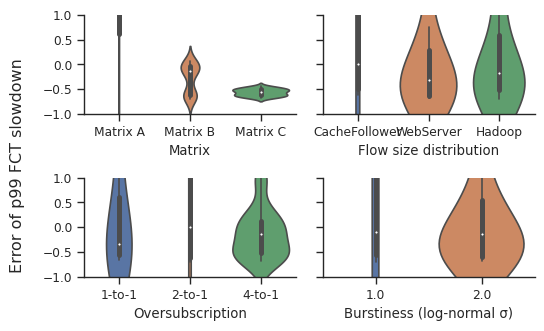

In [51]:
df_violin_lo = records[records['max_load'] <= records['max_load'].quantile(0.5)]
violins(df_violin_lo)
plt.savefig('figs/error-dist-1.pdf', bbox_inches='tight')

findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.


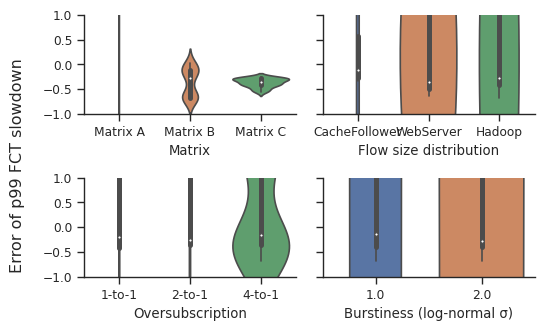

In [52]:
df_violin_hi = records[records['max_load'] > records['max_load'].quantile(0.5)]
violins(df_violin_hi)
plt.savefig('figs/error-dist-2.pdf', bbox_inches='tight')

## Scratch

In [21]:
alt.Chart(records).mark_point().encode(
    x=alt.X('max_load:Q'),
    y=alt.Y('p99__ns3__pmn_m:Q'),
    color=alt.Color('matrix:N'),
    shape=alt.Shape('size_dist:N'),
    size=alt.Size('lognorm_sigma:N'),
    opacity=alt.Opacity('oversub:N'),
    tooltip='id:N'
)

alt.Chart(...)